# Need to clone my REBOUND fork specifically, i.e., 

git clone https://github.com/dtamayo/rebound.git

- For resonant and TTV systems use commit 6fb912f615ca542b670ab591375191d1ed914672 (on master branch)
- For random and Naireen random systems use REBOUND commit 4a6c79ae14ffde27828dd9d1f8d8afeba94ef048 (on the spockrandomintegrations branch--currently HEAD)

The resonant and TTV (KOI-1576) systems use different REBOUND commits (a675e6f92cba32bae86f94739faec3b1b3098e81 for resonant). The problem is that this version doesn't have a __del__ function for the simulation archives and you get an error of too many open files when you run this. There was also a bug with keep_unsynchronized=1 and using MEGNO, so we now use the patch 06c95e2a69d319de3b077d92f2541cdcdf68a8fa. I test below that an integration that initializes MEGNO gives the same result as the original sim archives that don't. I then fixed something with collisions so the commit to use is 6fb912f615ca542b670ab591375191d1ed914672. Can see details in REBOUND repo pull requests.

The commit 4a6c79ae14ffde27828dd9d1f8d8afeba94ef048 on the spockrandomintegrations branch works for the random set of integrations. I had to branch from the old commit used to run the long integrations db3ae2cea8f3462463d3e0c5788a34625bb49a9c (actually it's not the exact one but close to it), and add the patches to calculate megno/lyap correctly with keep_unsynchronized=1 (which we need to match bit by bit). Had to update from 48feb327f90611a5569682578980b5604aa6102a to also keep pos/vel unsynchronized when using megno so that collisions are caught at the same time. In general I don't think  we want that in there (in our training dataset we are catching collisions with unsynchronized states, which is not correct, but statistically fine).
I also had to add jacobi_masses to sim.calculate_orbits in order for celmech to work correctly. This is the latest patch on top of the last, which was 361adacb48ff55ea8331adbf37a943e63ca02984.

The commit you load above will work for the corresponding set of archives loaded below. The others won't give identical results (or fail altogether). But the same testsim function can work on all which lets us always use the same function in generatedata/training_data_functions.py. 

When we ran the resonant integrations (with the new simarchive), we did with safe_mode = 0 so we don't repeat kepler half steps. This means the sim will be in an unsynchronized state (see simarchiverestart ipython_example) when we load any snapshot but the first one, so we have to synchronize before comparing output. 

We need to use sim.ri_whfast.keep_unsynchronized = 1 for reproducibility. A value of 1 means that even if you synchronize, you'll keep integrating from the unsynchronized state if you keep going. So when integrating through a list of times, we need to set this if we want to match the sim archives. 

# We keep the above (and this notebook) for our reference and that of anyone wanting to reproduce the exact chaotic trajectories in our long (1e9 orbit) integrations

The workarounds mentioned above were introduced so that the short integrations, which need to calculate the MEGNO, can match the long integrations. The issue is that the long integrations are run with ri_whfast.safe_mode=0, while the short integrations have to synchronize every timestep to calculate the MEGNO. The commits above therefore cache the unsynchronized states, and revert to them after calculating the MEGNO, yielding the same safe_mode = 0 trajectory. However, we found that calculating the MEGNO after each timestep using an inconsistent trajectory that always reverts to unsynchronized state causes a scale-dependence to the MEGNO--it's fine for natural units (G=4pi^2, distance = innermost semimajor axis, time =innermost orbital period), but for long period orbits MEGNO settles to > 2 instead of 2 for regular orbits.

So we decided to drop the requirement that we match the exact chaotic trajectory of the long integrations in the short integrations. This is also physically reasonable since both trajectories are equally valid draws from the distribution of chaotic trajectories associated with the initial condition. This also lets us use different timesteps (we now default to 0.05 smallest pericenter passage time) for both SPOCK and nbody. We checked that using these different chaotic realizations to predict the long term integrations had a negligible effect compared to using the exact same trajectories.

In summary, you can easily get the same trajectories as the long-term ones if you use safe_mode=0 (but can't calculate MEGNO), you can use the above commits to calculate MEGNO and use the same trajectories above if you use natural units (but there's a funny scale dependence otherwise), or you can use different chaotic realizations and it doesn't make a statistically significant difference.

# When comparing reruns to label instability times, note that instability sim.t has been divided by P0 = sim.particles[1].P at t=0

In [1]:
from platform import python_version
print(python_version() )
import rebound
print(rebound.__version__)

3.10.9
3.17.3


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import rebound
%matplotlib inline
#change it to my dictionary
datafolder = '/home/yba/spock/data/'
Nout = 1729


/mnt/ssd/home/yba/rebound/rebound/simulationarchive.py:99: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/home/yba/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/home/yba/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/home/yba/rebound/rebound/simulationarchive.py:146: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


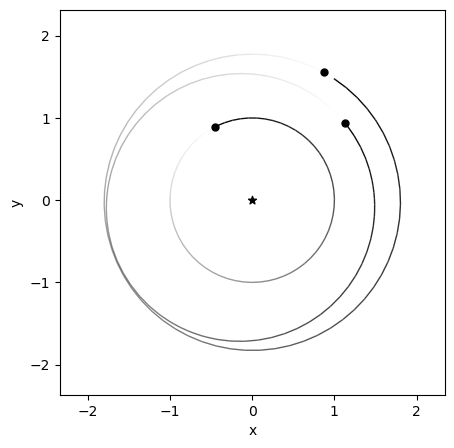

In [3]:
#for random -testing
# initial_condition_random
# not sure what is generate new data
# read one initial condition of specific planet
sa = rebound.SimulationArchive(datafolder+'random/simulation_archives/runs/sa0000008.bin')# read the file
sim2 = sa[0] # read the initial condition
fig = rebound.OrbitPlot(sim2) #plot it first

In [4]:
#old version

from collections import OrderedDict
import sys
sys.path.append('../spock')
sys.path.append('../../spock')
from simsetup import init_sim_parameters
from feature_functions import features

kwargs = OrderedDict()
kwargs['Norbits'] = 1e4
kwargs['Nout'] = 80 
kwargs['trio'] = [[1,2,3]]
sim2.status()
args = list(kwargs.values())
init_sim_parameters(sim2)
ret, stable = features(sim2, args)
print(ret, stable)

---------------------------------
REBOUND version:     	3.17.3
REBOUND built on:    	Sep 28 2023 17:41:01
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.034641
---------------------------------
<rebound.particle.Particle object at 0x7f90d97b9cc0, m=1.0 x=-8.73986082930694e-05 y=-7.270203229937109e-05 z=6.580751199372855e-07 vx=0.00026624376058677525 vy=-0.00032602176633684187 vz=-2.4726767103449343e-06>
<rebound.particle.Particle object at 0x7f90d97ba240, m=4.787596911513267e-07 x=-0.4564528084842913 y=0.8888276926367595 z=0.014267736535836873 vx=-5.5885956943149635 vy=-2.8797696013905805 vz=0.08077365482463945>
<rebound.particle.Particle object at 0x7f90d97b9cc0, m=7.706995537180603e-05 x=1.1341540353301762 y=0.9329802535632888 z=-0.008582873434461824 vx=-3.406956472151463 vy=4.241019429858991 vz=0.03157247382648557>
<rebound.particle.Particle object at 0x7f90d97ba240, m=2.393275505503038e-07 x=0.86884527316631

/tmp/ipykernel_142653/3159053292.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv('/home/yba/spock/training_data/random/runstrings.csv', header=None, index_col=0, squeeze=True)


(<Figure size 500x500 with 1 Axes>, <AxesSubplot: xlabel='x', ylabel='y'>)

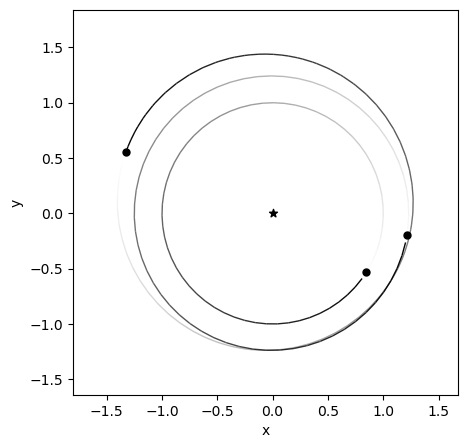

In [18]:
#testing
df = pd.read_csv('/home/yba/spock/training_data/random/runstrings.csv', header=None, index_col=0, squeeze=True)

# convert the dataframe into a dictionary
my_dict = df.to_dict()

# the binary file name you want to search for
binary_file_name = "8536642.bin"

# search for the binary file name in the dictionary
for key, value in my_dict.items():
    if value == binary_file_name:
        i = int(key)


all_data = np.loadtxt('/home/yba/spock/data/resonant/initial_conditions.csv', delimiter=',',dtype=np.float64)
# get corresponding row
data = all_data[i]
# create a new simulation
sim = rebound.Simulation()
sim.G=4*np.pi**2
sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
sim.add(m=data[14], x=data[15], y=data[16], z=data[17], vx=data[18], vy=data[19], vz=data[20])
sim.add(m=data[21], x=data[22], y=data[23], z=data[24], vx=data[25], vy=data[26], vz=data[27])

rebound.OrbitPlot(sim)

/tmp/ipykernel_142653/1538122121.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv('/home/yba/spock/training_data/resonant/runstrings.csv', header=None, index_col=0, squeeze=True)


(<Figure size 500x500 with 1 Axes>, <AxesSubplot: xlabel='x', ylabel='y'>)

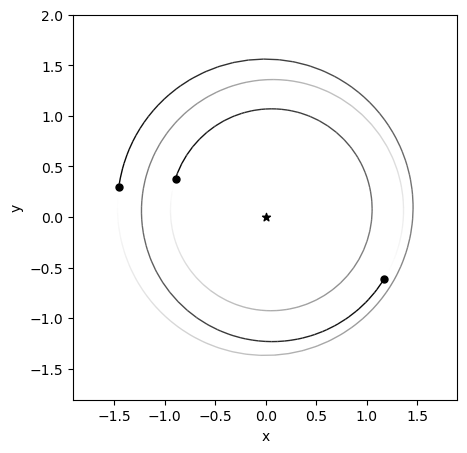

In [47]:
#testing
df = pd.read_csv('/home/yba/spock/training_data/resonant/runstrings.csv', header=None, index_col=0, squeeze=True)

# convert the dataframe into a dictionary
my_dict = df.to_dict()

# the binary file name you want to search for
binary_file_name = "8536642.bin"

# search for the binary file name in the dictionary
for key, value in my_dict.items():
    if value == binary_file_name:
        i = int(key)

all_data = np.loadtxt('/home/yba/spock/data/resonant/initial_conditions.csv', delimiter=',',dtype=np.float64)
# get corresponding row
data = all_data[i]
# create a new simulation3
sim = rebound.Simulation()
sim.G=4*np.pi**2
sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
sim.add(m=data[14], x=data[15], y=data[16], z=data[17], vx=data[18], vy=data[19], vz=data[20])
sim.add(m=data[21], x=data[22], y=data[23], z=data[24], vx=data[25], vy=data[26], vz=data[27])

rebound.OrbitPlot(sim)

In [51]:
from collections import OrderedDict
import sys
sys.path.append('../spock')
sys.path.append('../../spock')
from simsetup import init_sim_parameters
from feature_functions import features

kwargs = OrderedDict()
kwargs['Norbits'] = 1e4
kwargs['Nout'] = 80 
kwargs['trio'] = [[1,2,3]]
args = list(kwargs.values())
init_sim_parameters(sim)


In [54]:
#features function

import rebound
import numpy as np
from collections import OrderedDict

######################### Taken from celmech github.com/shadden/celmech
def farey_sequence(n):
    """Return the nth Farey sequence as order pairs of the form (N,D) where `N' is the numerator and `D' is the denominator."""
    a, b, c, d = 0, 1, 1, n
    sequence=[(a,b)]
    while (c <= n):
        k = int((n + b) / d)
        a, b, c, d = c, d, (k*c-a), (k*d-b)
        sequence.append( (a,b) )
    return sequence
def resonant_period_ratios(min_per_ratio,max_per_ratio,order):
    """Return the period ratios of all resonances up to order 'order' between 'min_per_ratio' and 'max_per_ratio' """
    if min_per_ratio < 0.:
        raise AttributeError("min_per_ratio of {0} passed to resonant_period_ratios can't be < 0".format(min_per_ratio))
    if max_per_ratio >= 1.:
        raise AttributeError("max_per_ratio of {0} passed to resonant_period_ratios can't be >= 1".format(max_per_ratio))
    minJ = int(np.floor(1. /(1. - min_per_ratio)))
    maxJ = int(np.ceil(1. /(1. - max_per_ratio)))
    res_ratios=[(minJ-1,minJ)]
    for j in range(minJ,maxJ):
        res_ratios = res_ratios + [ ( x[1] * j - x[1] + x[0] , x[1] * j + x[0]) for x in farey_sequence(order)[1:] ]
    res_ratios = np.array(res_ratios)
    msk = np.array( list(map( lambda x: min_per_ratio < x[0]/float(x[1]) < max_per_ratio , res_ratios )) )
    return res_ratios[msk]
##########################

# sorts out which pair of planets has a smaller EMcross, labels that pair inner, other adjacent pair outer
# returns a list of two lists, with [label (near or far), i1, i2], where i1 and i2 are the indices, with i1 
# having the smaller semimajor axis
def get_pairs(sim, indices):
    ps = sim.particles
    sortedindices = sorted(indices, key=lambda i: ps[i].a) # sort from inner to outer
    EMcrossInner = (ps[sortedindices[1]].a-ps[sortedindices[0]].a)/ps[sortedindices[0]].a
    EMcrossOuter = (ps[sortedindices[2]].a-ps[sortedindices[1]].a)/ps[sortedindices[1]].a

    if EMcrossInner < EMcrossOuter:
        return [['near', sortedindices[0], sortedindices[1]], ['far', sortedindices[1], sortedindices[2]]]
    else:
        return [['near', sortedindices[1], sortedindices[2]], ['far', sortedindices[0], sortedindices[1]]]

def find_strongest_MMR(sim, i1, i2):
    maxorder = 2
    ps = sim.particles
    n1 = ps[i1].n
    n2 = ps[i2].n

    m1 = ps[i1].m/ps[0].m
    m2 = ps[i2].m/ps[0].m

    Pratio = n2/n1

    delta = 0.03
    if Pratio < 0 or Pratio > 1: # n < 0 = hyperbolic orbit, Pratio > 1 = orbits are crossing
        return np.nan, np.nan, np.nan

    minperiodratio = max(Pratio-delta, 0.)
    maxperiodratio = min(Pratio+delta, 0.99) # too many resonances close to 1
    res = resonant_period_ratios(minperiodratio,maxperiodratio, order=2)

    # Calculating EM exactly would have to be done in celmech for each j/k res below, and would slow things down. This is good enough for approx expression
    EM = np.sqrt((ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega))**2 + (ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega))**2)
    EMcross = (ps[i2].a-ps[i1].a)/ps[i1].a

    j, k, maxstrength = np.nan, np.nan, 0 
    for a, b in res:
        nres = (b*n2 - a*n1)/n1
        if nres == 0:
            s = np.inf # still want to identify as strongest MMR if initial condition is exatly b*n2-a*n1 = 0
        else:
            s = np.abs(np.sqrt(m1+m2)*(EM/EMcross)**((b-a)/2.)/nres)
        if s > maxstrength:
            j = b
            k = b-a
            maxstrength = s
    if maxstrength == 0:
        maxstrength = np.nan

    return j, k, maxstrength

def populate_trio(sim, trio, pairs, tseries, i):
    Ns = 3
    ps = sim.particles
    for q, [label, i1, i2] in enumerate(pairs):
        m1 = ps[i1].m
        m2 = ps[i2].m
        e1x, e1y = ps[i1].e*np.cos(ps[i1].pomega), ps[i1].e*np.sin(ps[i1].pomega)
        e2x, e2y = ps[i2].e*np.cos(ps[i2].pomega), ps[i2].e*np.sin(ps[i2].pomega)
        tseries[i,Ns*q+1] = np.sqrt((e2x-e1x)**2 + (e2y-e1y)**2)
        tseries[i,Ns*q+2] = np.sqrt((m1*e1x + m2*e2x)**2 + (m1*e1y + m2*e2y)**2)/(m1+m2)
        j, k, tseries[i,Ns*q+3] = find_strongest_MMR(sim, i1, i2) 

    tseries[i,7] = sim.calculate_megno() # megno

def get_tseries(sim, args):
    mtotal = sim.particles[1].m + sim.particles[2].m  + sim.particles[3].m
    alpha13 = sim.particles[1].a / sim.particles[3].a 
    ec13 = 1-alpha13 
    Tsec = 4* sim.particles[0].m/mtotal * ec13 * ec13  * sim.particles[3].P
    Norbits = 0.3* Tsec
    Nout = args[1]
    trios = args[2]
    
    minP = np.min([p.P for p in sim.particles[1:sim.N_real]])

    # want hyperbolic case to run so it raises exception
    times = np.linspace(0, Norbits*np.abs(minP), Nout)
    
    triopairs, triotseries = [], []
    for tr, trio in enumerate(trios): # For each trio there are two adjacent pairs 
        triopairs.append(get_pairs(sim, trio))
        triotseries.append(np.zeros((Nout, 8))*np.nan)

    if np.isnan(sim.dt): # initially hyperbolic orbit, set in simsetup/set_integrator_and_timestep
        stable = False
        return triotseries, stable

    for i, time in enumerate(times):
        try:
            sim.integrate(time, exact_finish_time=0)
        except (rebound.Collision, rebound.Escape):
            stable = False
            print(sim.t)
            return triotseries, stable

        for tseries in triotseries:
            tseries[i,0] = sim.t/minP  # time

        for tr, trio in enumerate(trios):
            pairs = triopairs[tr]
            tseries = triotseries[tr] 
            populate_trio(sim, trio, pairs, tseries, i)
    
    stable = True
    return triotseries, stable


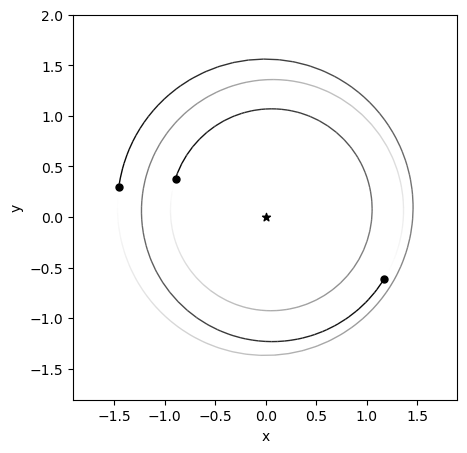

In [55]:
rebound.OrbitPlot(sim)
mtotal = sim.particles[1].m + sim.particles[2].m  + sim.particles[3].m
alpha13 = sim.particles[1].a / sim.particles[3].a 
ec13 = 1-alpha13 
Tsec = 4* sim.particles[0].m/mtotal * ec13 * ec13  * sim.particles[3].P
Norbits = 0.3* Tsec
Nout = args[1]
trios = args[2]

ps  = sim.particles
triofeatures = []
for tr, trio in enumerate(trios):
    features = OrderedDict()
    pairs = get_pairs(sim, trio)
    for i, [label, i1, i2] in enumerate(pairs):
        features['EMcross'+label] = (ps[i2].a-ps[i1].a)/ps[i1].a
        features['EMfracstd'+label] = np.nan
        features['EPstd'+label] = np.nan
        features['MMRstrength'+label] = np.nan

    features['MEGNO'] = np.nan
    features['MEGNOstd'] = np.nan
    triofeatures.append(features)

triotseries, stable = get_tseries(sim, args)
if stable == False:
    print(triofeatures, stable)
    

for features, tseries in zip(triofeatures, triotseries):
    EMnear = tseries[:, 1]
    EPnear = tseries[:, 2]
    # cut out first value (init cond) to avoid cases
    # where user sets exactly b*n2 - a*n1 & strength is inf
    MMRstrengthnear = tseries[1:,3]
    EMfar = tseries[:, 4]
    EPfar = tseries[:, 5]
    MMRstrengthfar = tseries[1:,6]
    MEGNO = tseries[:, 7]

    if not np.isnan(MEGNO).any(): # no nans
        features['MEGNO'] = np.median(MEGNO[-int(Nout/10):]) # smooth last 10% to remove oscillations around 2
        features['MEGNOstd'] = MEGNO[int(Nout/5):].std()
    features['MMRstrengthnear'] = np.median(MMRstrengthnear)
    features['MMRstrengthfar'] = np.median(MMRstrengthfar)
    features['EMfracstdnear'] = EMnear.std() / features['EMcrossnear']
    features['EMfracstdfar'] = EMfar.std() / features['EMcrossfar']
    features['EPstdnear'] = EPnear.std() 
    features['EPstdfar'] = EPfar.std() 



In [56]:
print(features)

OrderedDict([('EMcrossnear', 0.12928803945699316), ('EMfracstdnear', 0.04793734206319272), ('EPstdnear', 0.00036861762424861895), ('MMRstrengthnear', 1.04340529347771), ('EMcrossfar', 0.29782633973416245), ('EMfracstdfar', 0.10633954607666317), ('EPstdfar', 0.011524834994828308), ('MMRstrengthfar', 0.03403621228119662), ('MEGNO', 2.042891009283813), ('MEGNOstd', 0.00682476350649193)])


/mnt/ssd/home/yba/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/home/yba/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/home/yba/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


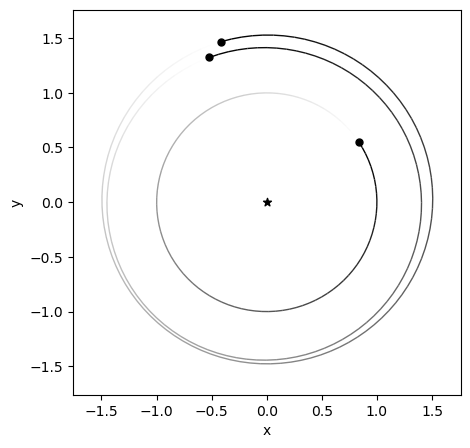

In [52]:
#for resonant-testing
# initial_condition_random
# not sure what is generate new data
# read one initial condition of specific planet
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa0000835.bin')# read the file
sim2 = sa[0] # read the initial condition
fig = rebound.OrbitPlot(sim2) #plot it first

/tmp/ipykernel_296319/835338922.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv('/home/yba/spock/training_data/random/runstrings.csv', header=None, index_col=0, squeeze=True)


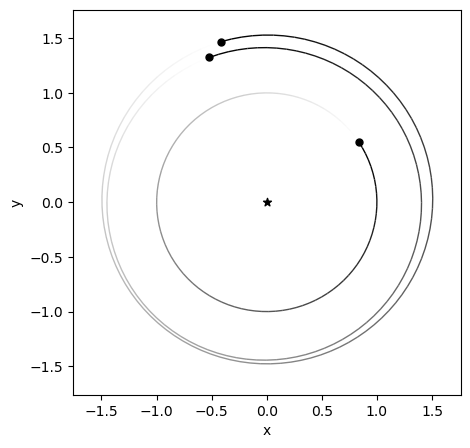

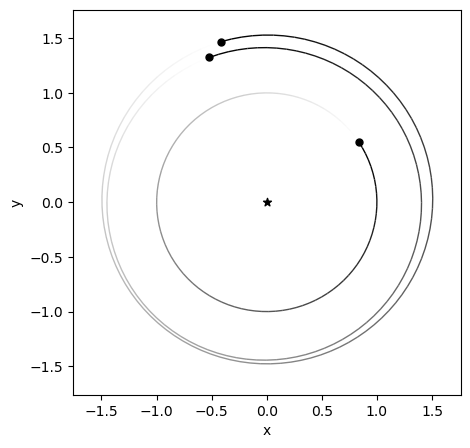

In [30]:
#testing
df = pd.read_csv('/home/yba/spock/training_data/random/runstrings.csv', header=None, index_col=0, squeeze=True)

# convert the dataframe into a dictionary
my_dict = df.to_dict()

# the binary file name you want to search for
binary_file_name = "0000835.bin"

# search for the binary file name in the dictionary
for key, value in my_dict.items():
    if value == binary_file_name:
        i = int(key)


all_data = np.loadtxt('initial_condition_resonant.csv', delimiter=',',dtype=np.float64)
# get corresponding row
data = all_data[i]
# create a new simulation
sim = rebound.Simulation()
sim.G=4*np.pi**2
sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
sim.add(m=data[14], x=data[15], y=data[16], z=data[17], vx=data[18], vy=data[19], vz=data[20])
sim.add(m=data[21], x=data[22], y=data[23], z=data[24], vx=data[25], vy=data[26], vz=data[27])

rebound.OrbitPlot(sim)

In [23]:
# read the mass of four planet
m0 = sim.particles[0].m
m1 = sim.particles[1].m
m2 = sim.particles[2].m
m3 = sim.particles[3].m

vx0 = sim.particles[0].vx
vx1 = sim.particles[1].vx
vx2 = sim.particles[2].vx
vx3 = sim.particles[3].vx

vy0 = sim.particles[0].vy
vy1 = sim.particles[1].vy
vy2 = sim.particles[2].vy
vy3 = sim.particles[3].vy

vz0 = sim.particles[0].vz
vz1 = sim.particles[1].vz
vz2 = sim.particles[2].vz
vz3 = sim.particles[3].vz

x0 = sim.particles[0].x
x1 = sim.particles[1].x
x2 = sim.particles[2].x
x3 = sim.particles[3].x

y0 = sim.particles[0].y
y1 = sim.particles[1].y
y2 = sim.particles[2].y
y3 = sim.particles[3].y

z0 = sim.particles[0].z
z1 = sim.particles[1].z
z2 = sim.particles[2].z
z3 = sim.particles[3].z

n = np.array([m0, x0, y0, z0, vx0, vy0, vz0, m1, x1, y1, z1, vx1, vy1, vz1, m2, x2, y2, z2, vx2, vy2, vz2, m3, x3, y3, z3, vx3, vy3, vz3])
print(n)

[ 1.00000000e+00  5.49253312e-05 -1.21633728e-04 -6.84386876e-07
  4.42754505e-04  1.94756534e-04  4.38397374e-06  1.64854089e-07
 -5.77455701e-01 -8.43939439e-01  8.50802626e-02  5.06585094e+00
 -3.43639440e+00  7.10734172e-02  1.69935988e-06  1.01256772e+00
 -1.51883503e-01 -1.48564211e-02  9.03282342e-01  6.25863133e+00
  2.88297546e-01  9.34897825e-05 -6.04888050e-01  1.30528660e+00
  7.44046498e-03 -4.76121156e+00 -2.19088859e+00 -5.22582430e-02]


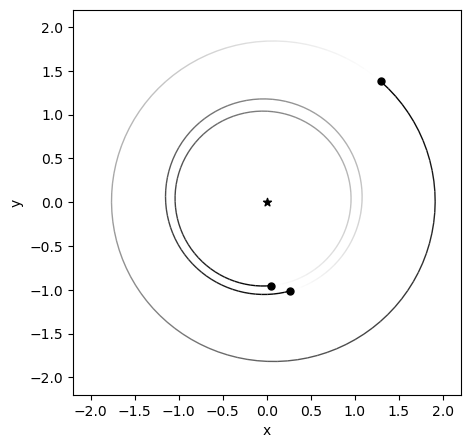

In [11]:
# for resonant
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa0004009.bin')# read the file
sim = sa[0] # read the initial condition
fig = rebound.OrbitPlot(sim) #plot it first

In [ ]:
# read the mass of four planet
m0 = sim.particles[0].m
m1 = sim.particles[1].m
m2 = sim.particles[2].m
m3 = sim.particles[3].m

vx0 = sim.particles[0].vx
vx1 = sim.particles[1].vx
vx2 = sim.particles[2].vx
vx3 = sim.particles[3].vx

vy0 = sim.particles[0].vy
vy1 = sim.particles[1].vy
vy2 = sim.particles[2].vy
vy3 = sim.particles[3].vy

vz0 = sim.particles[0].vz
vz1 = sim.particles[1].vz
vz2 = sim.particles[2].vz
vz3 = sim.particles[3].vz

x0 = sim.particles[0].x
x1 = sim.particles[1].x
x2 = sim.particles[2].x
x3 = sim.particles[3].x

y0 = sim.particles[0].y
y1 = sim.particles[1].y
y2 = sim.particles[2].y
y3 = sim.particles[3].y

z0 = sim.particles[0].z
z1 = sim.particles[1].z
z2 = sim.particles[2].z
z3 = sim.particles[3].z

n = np.array([m0, x0, y0, z0, vx0, vy0, vz0, m1, x1, y1, z1, vx1, vy1, vz1, m2, x2, y2, z2, vx2, vy2, vz2, m3, x3, y3, z3, vx3, vy3, vz3])
print(n)

In [8]:
# write all initial condition of random dataset to csv file
with open('initial_condition_random.csv', 'w') as f:
    for i in range(25000):
        fileName = f"sa{i:07d}.bin"
        # find the corresponding file
        sa = rebound.SimulationArchive(datafolder+"random/simulation_archives/runs/"+fileName)# read the file
        sim = sa[0] # read the initial condition
        m0 = sim.particles[0].m
        m1 = sim.particles[1].m
        m2 = sim.particles[2].m
        m3 = sim.particles[3].m

        vx0 = sim.particles[0].vx
        vx1 = sim.particles[1].vx
        vx2 = sim.particles[2].vx
        vx3 = sim.particles[3].vx

        vy0 = sim.particles[0].vy
        vy1 = sim.particles[1].vy
        vy2 = sim.particles[2].vy
        vy3 = sim.particles[3].vy

        vz0 = sim.particles[0].vz
        vz1 = sim.particles[1].vz
        vz2 = sim.particles[2].vz
        vz3 = sim.particles[3].vz

        x0 = sim.particles[0].x
        x1 = sim.particles[1].x
        x2 = sim.particles[2].x
        x3 = sim.particles[3].x

        y0 = sim.particles[0].y
        y1 = sim.particles[1].y
        y2 = sim.particles[2].y
        y3 = sim.particles[3].y

        z0 = sim.particles[0].z
        z1 = sim.particles[1].z
        z2 = sim.particles[2].z
        z3 = sim.particles[3].z

        data = [m0, x0, y0, z0, vx0, vy0, vz0, m1, x1, y1, z1, vx1, vy1, vz1, m2, x2, y2, z2, vx2, vy2, vz2, m3, x3, y3, z3, vx3, vy3, vz3]  # Create an example row of data
        np.savetxt(f, [data], delimiter=',',fmt='%0.16f')  # Write the row to the file


In [3]:
with open('data_resonant.csv', 'w') as f:
    for i in range(9045384):
        fileName = f"sa{i:07d}.bin"
        try:
            # find the corresponding file
            sa = rebound.SimulationArchive(datafolder+"resonant/simulation_archives/runs/"+fileName)# read the file
            sim = sa[0] # read the initial condition
            print(fileName)
            m0 = sim.particles[0].m
            m1 = sim.particles[1].m
            m2 = sim.particles[2].m
            m3 = sim.particles[3].m

            vx0 = sim.particles[0].vx
            vx1 = sim.particles[1].vx
            vx2 = sim.particles[2].vx
            vx3 = sim.particles[3].vx

            vy0 = sim.particles[0].vy
            vy1 = sim.particles[1].vy
            vy2 = sim.particles[2].vy
            vy3 = sim.particles[3].vy

            vz0 = sim.particles[0].vz
            vz1 = sim.particles[1].vz
            vz2 = sim.particles[2].vz
            vz3 = sim.particles[3].vz

            x0 = sim.particles[0].x
            x1 = sim.particles[1].x
            x2 = sim.particles[2].x
            x3 = sim.particles[3].x

            y0 = sim.particles[0].y
            y1 = sim.particles[1].y
            y2 = sim.particles[2].y
            y3 = sim.particles[3].y

            z0 = sim.particles[0].z
            z1 = sim.particles[1].z
            z2 = sim.particles[2].z
            z3 = sim.particles[3].z

            data = [m0, x0, y0, z0, vx0, vy0, vz0, m1, x1, y1, z1, vx1, vy1, vz1, m2, x2, y2, z2, vx2, vy2, vz2, m3, x3, y3, z3, vx3, vy3, vz3]  # Create an example row of data
            # np.savetxt(f, [data], delimiter=',',fmt='%0.16f')  # Write the row to the fil
            del sa
        except:
            print("Error in " + fileName)


sa0000000.bin
sa0000001.bin
sa0000002.bin
sa0000003.bin
sa0000004.bin
sa0000005.bin
sa0000006.bin
sa0000007.bin
sa0000008.bin
sa0000009.bin
sa0000010.bin
sa0000011.bin
sa0000012.bin
sa0000013.bin
sa0000014.bin
sa0000015.bin
sa0000016.bin
sa0000017.bin
sa0000018.bin
sa0000019.bin
sa0000020.bin
sa0000021.bin
sa0000022.bin
sa0000023.bin
sa0000024.bin
sa0000025.bin
sa0000026.bin
sa0000027.bin
sa0000028.bin
sa0000029.bin
sa0000030.bin
sa0000031.bin
sa0000032.bin
sa0000033.bin
sa0000034.bin
sa0000035.bin
sa0000036.bin
sa0000037.bin
sa0000038.bin
sa0000039.bin
sa0000040.bin
sa0000041.bin
sa0000042.bin
sa0000043.bin
sa0000044.bin
sa0000045.bin
sa0000046.bin
sa0000047.bin
sa0000048.bin
sa0000049.bin
sa0000050.bin
sa0000051.bin
sa0000052.bin
sa0000053.bin
sa0000054.bin
sa0000055.bin
sa0000056.bin
sa0000057.bin
sa0000058.bin
sa0000059.bin
sa0000060.bin
sa0000061.bin
sa0000062.bin
sa0000063.bin
sa0000064.bin
sa0000065.bin
sa0000066.bin
sa0000067.bin
sa0000068.bin
sa0000069.bin
sa0000070.bin
sa0000

sa0000618.bin
sa0000619.bin
sa0000620.bin
sa0000621.bin
sa0000622.bin
sa0000623.bin
sa0000624.bin
sa0000625.bin
sa0000626.bin
sa0000627.bin
sa0000628.bin
sa0000629.bin
sa0000630.bin
sa0000631.bin
sa0000632.bin
sa0000633.bin
sa0000634.bin
sa0000635.bin
sa0000636.bin
sa0000637.bin
sa0000638.bin
sa0000639.bin
sa0000640.bin
sa0000641.bin
sa0000642.bin
sa0000643.bin
sa0000644.bin
sa0000645.bin
sa0000646.bin
sa0000647.bin
sa0000648.bin
sa0000649.bin
sa0000650.bin
sa0000651.bin
sa0000652.bin
sa0000653.bin
sa0000654.bin
sa0000655.bin
sa0000656.bin
sa0000657.bin
sa0000658.bin
sa0000659.bin
sa0000660.bin
sa0000661.bin
sa0000662.bin
sa0000663.bin
sa0000664.bin
sa0000665.bin
sa0000666.bin
sa0000667.bin
sa0000668.bin
sa0000669.bin
sa0000670.bin
sa0000671.bin
sa0000672.bin
sa0000673.bin
sa0000674.bin
sa0000675.bin
sa0000676.bin
sa0000677.bin
sa0000678.bin
sa0000679.bin
sa0000680.bin
sa0000681.bin
sa0000682.bin
sa0000683.bin
sa0000684.bin
sa0000685.bin
sa0000686.bin
sa0000687.bin
sa0000688.bin
sa0000

sa0001215.bin
sa0001216.bin
sa0001217.bin
sa0001218.bin
sa0001219.bin
sa0001220.bin
sa0001221.bin
sa0001222.bin
sa0001223.bin
sa0001224.bin
sa0001225.bin
sa0001226.bin
sa0001227.bin
sa0001228.bin
sa0001229.bin
sa0001230.bin
sa0001231.bin
sa0001232.bin
sa0001233.bin
sa0001234.bin
sa0001235.bin
sa0001236.bin
sa0001237.bin
sa0001238.bin
sa0001239.bin
sa0001240.bin
sa0001241.bin
sa0001242.bin
sa0001243.bin
sa0001244.bin
sa0001245.bin
sa0001246.bin
sa0001247.bin
sa0001248.bin
sa0001249.bin
sa0001250.bin
sa0001251.bin
sa0001252.bin
sa0001253.bin
sa0001254.bin
sa0001255.bin
sa0001256.bin
sa0001257.bin
sa0001258.bin
sa0001259.bin
sa0001260.bin
sa0001261.bin
sa0001262.bin
sa0001263.bin
sa0001264.bin
sa0001265.bin
sa0001266.bin
sa0001267.bin
sa0001268.bin
sa0001269.bin
sa0001270.bin
sa0001271.bin
sa0001272.bin
sa0001273.bin
sa0001274.bin
sa0001275.bin
sa0001276.bin
sa0001277.bin
sa0001278.bin
sa0001279.bin
sa0001280.bin
sa0001281.bin
sa0001282.bin
sa0001283.bin
sa0001284.bin
sa0001285.bin
sa0001

sa0001889.bin
sa0001890.bin
sa0001891.bin
sa0001892.bin
sa0001893.bin
sa0001894.bin
sa0001895.bin
sa0001896.bin
sa0001897.bin
sa0001898.bin
sa0001899.bin
sa0001900.bin
sa0001901.bin
sa0001902.bin
sa0001903.bin
sa0001904.bin
sa0001905.bin
sa0001906.bin
sa0001907.bin
sa0001908.bin
sa0001909.bin
sa0001910.bin
sa0001911.bin
sa0001912.bin
sa0001913.bin
sa0001914.bin
sa0001915.bin
sa0001916.bin
sa0001917.bin
sa0001918.bin
sa0001919.bin
sa0001920.bin
sa0001921.bin
sa0001922.bin
sa0001923.bin
sa0001924.bin
sa0001925.bin
sa0001926.bin
sa0001927.bin
sa0001928.bin
sa0001929.bin
sa0001930.bin
sa0001931.bin
sa0001932.bin
sa0001933.bin
sa0001934.bin
sa0001935.bin
sa0001936.bin
sa0001937.bin
sa0001938.bin
sa0001939.bin
sa0001940.bin
sa0001941.bin
sa0001942.bin
sa0001943.bin
sa0001944.bin
sa0001945.bin
sa0001946.bin
sa0001947.bin
sa0001948.bin
sa0001949.bin
sa0001950.bin
sa0001951.bin
sa0001952.bin
sa0001953.bin
sa0001954.bin
sa0001955.bin
sa0001956.bin
sa0001957.bin
sa0001958.bin
sa0001959.bin
sa0001

sa0002560.bin
sa0002561.bin
sa0002562.bin
sa0002563.bin
sa0002564.bin
sa0002565.bin
sa0002566.bin
sa0002567.bin
sa0002568.bin
sa0002569.bin
sa0002570.bin
sa0002571.bin
sa0002572.bin
sa0002573.bin
sa0002574.bin
sa0002575.bin
sa0002576.bin
sa0002577.bin
sa0002578.bin
sa0002579.bin
sa0002580.bin
sa0002581.bin
sa0002582.bin
sa0002583.bin
sa0002584.bin
sa0002585.bin
sa0002586.bin
sa0002587.bin
sa0002588.bin
sa0002589.bin
sa0002590.bin
sa0002591.bin
sa0002592.bin
sa0002593.bin
sa0002594.bin
sa0002595.bin
sa0002596.bin
sa0002597.bin
sa0002598.bin
sa0002599.bin
sa0002600.bin
sa0002601.bin
sa0002602.bin
sa0002603.bin
sa0002604.bin
sa0002605.bin
sa0002606.bin
sa0002607.bin
sa0002608.bin
sa0002609.bin
sa0002610.bin
sa0002611.bin
sa0002612.bin
sa0002613.bin
sa0002614.bin
sa0002615.bin
sa0002616.bin
sa0002617.bin
sa0002618.bin
sa0002619.bin
sa0002620.bin
sa0002621.bin
sa0002622.bin
sa0002623.bin
sa0002624.bin
sa0002625.bin
sa0002626.bin
sa0002627.bin
sa0002628.bin
sa0002629.bin
sa0002630.bin
sa0002

sa0003190.bin
sa0003191.bin
sa0003192.bin
sa0003193.bin
sa0003194.bin
sa0003195.bin
sa0003196.bin
sa0003197.bin
sa0003198.bin
sa0003199.bin
sa0003200.bin
sa0003201.bin
sa0003202.bin
sa0003203.bin
sa0003204.bin
sa0003205.bin
sa0003206.bin
sa0003207.bin
sa0003208.bin
sa0003209.bin
sa0003210.bin
sa0003211.bin
sa0003212.bin
sa0003213.bin
sa0003214.bin
sa0003215.bin
sa0003216.bin
sa0003217.bin
sa0003218.bin
sa0003219.bin
sa0003220.bin
sa0003221.bin
sa0003222.bin
sa0003223.bin
sa0003224.bin
sa0003225.bin
sa0003226.bin
sa0003227.bin
sa0003228.bin
sa0003229.bin
sa0003230.bin
sa0003231.bin
sa0003232.bin
sa0003233.bin
sa0003234.bin
sa0003235.bin
sa0003236.bin
sa0003237.bin
sa0003238.bin
sa0003239.bin
sa0003240.bin
sa0003241.bin
sa0003242.bin
sa0003243.bin
sa0003244.bin
sa0003245.bin
sa0003246.bin
sa0003247.bin
sa0003248.bin
sa0003249.bin
sa0003250.bin
sa0003251.bin
sa0003252.bin
sa0003253.bin
sa0003254.bin
sa0003255.bin
sa0003256.bin
sa0003257.bin
sa0003258.bin
sa0003259.bin
sa0003260.bin
sa0003

sa0003790.bin
sa0003791.bin
sa0003792.bin
sa0003793.bin
sa0003794.bin
sa0003795.bin
sa0003796.bin
sa0003797.bin
sa0003798.bin
sa0003799.bin
sa0003800.bin
sa0003801.bin
sa0003802.bin
sa0003803.bin
sa0003804.bin
sa0003805.bin
sa0003806.bin
sa0003807.bin
sa0003808.bin
sa0003809.bin
sa0003810.bin
sa0003811.bin
sa0003812.bin
sa0003813.bin
sa0003814.bin
sa0003815.bin
sa0003816.bin
sa0003817.bin
sa0003818.bin
sa0003819.bin
sa0003820.bin
sa0003821.bin
sa0003822.bin
sa0003823.bin
sa0003824.bin
sa0003825.bin
sa0003826.bin
sa0003827.bin
sa0003828.bin
sa0003829.bin
sa0003830.bin
sa0003831.bin
sa0003832.bin
sa0003833.bin
sa0003834.bin
sa0003835.bin
sa0003836.bin
sa0003837.bin
sa0003838.bin
sa0003839.bin
sa0003840.bin
sa0003841.bin
sa0003842.bin
sa0003843.bin
sa0003844.bin
sa0003845.bin
sa0003846.bin
sa0003847.bin
sa0003848.bin
sa0003849.bin
sa0003850.bin
sa0003851.bin
sa0003852.bin
sa0003853.bin
sa0003854.bin
sa0003855.bin
sa0003856.bin
sa0003857.bin
sa0003858.bin
sa0003859.bin
sa0003860.bin
sa0003

In [8]:
def run(filename):
    try:
        # find the corresponding file
        sa = rebound.SimulationArchive(datafolder+"resonant/simulation_archives/runs/"+filename)# read the file
        sim = sa[0] # read the initial condition
        m0 = sim.particles[0].m
        m1 = sim.particles[1].m
        m2 = sim.particles[2].m
        m3 = sim.particles[3].m

        vx0 = sim.particles[0].vx
        vx1 = sim.particles[1].vx
        vx2 = sim.particles[2].vx
        vx3 = sim.particles[3].vx

        vy0 = sim.particles[0].vy
        vy1 = sim.particles[1].vy
        vy2 = sim.particles[2].vy
        vy3 = sim.particles[3].vy

        vz0 = sim.particles[0].vz
        vz1 = sim.particles[1].vz
        vz2 = sim.particles[2].vz
        vz3 = sim.particles[3].vz

        x0 = sim.particles[0].x
        x1 = sim.particles[1].x
        x2 = sim.particles[2].x
        x3 = sim.particles[3].x

        y0 = sim.particles[0].y
        y1 = sim.particles[1].y
        y2 = sim.particles[2].y
        y3 = sim.particles[3].y

        z0 = sim.particles[0].z
        z1 = sim.particles[1].z
        z2 = sim.particles[2].z
        z3 = sim.particles[3].z

        data = [m0, x0, y0, z0, vx0, vy0, vz0, m1, x1, y1, z1, vx1, vy1, vz1, m2, x2, y2, z2, vx2, vy2, vz2, m3, x3, y3, z3, vx3, vy3, vz3]  # Create an example row of data
        del sa
        return data
    except:
        with open('/home/yba/spock/generate_training_data/errors.csv', 'w') as e:
            e.write("{0}\n".format(filename))
            print("Error in " + fileName)

In [5]:
try:
    data = np.loadtxt('data_resonant.csv', delimiter=',',dtype=np.float64)
    start = data.shape[0]+1
    print(start)
    data = list(data)
except:
    data = []
    start = 0
    
for i in range(1900, 2100):
    fileName = f"sa{i:07d}.bin"
    ret = run(fileName)
    if ret:
        data.append(ret)
with open('initial_condition_resonant.csv', 'w') as f:
    np.savetxt(f, data, delimiter=',',fmt='%0.16f')        

NameError: name 'run' is not defined

/mnt/ssd/miniconda3/envs/yolanda/lib/python3.8/site-packages/rebound/simulationarchive.py:83: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/miniconda3/envs/yolanda/lib/python3.8/site-packages/rebound/simulationarchive.py:123: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/miniconda3/envs/yolanda/lib/python3.8/site-packages/rebound/simulationarchive.py:123: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


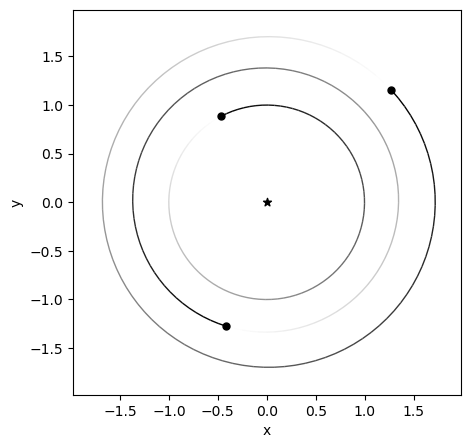

In [161]:
# for resonant - loading
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa7622393.bin') # read the file
sim2 = sa[0]   # read the initial condition
fig = rebound.OrbitPlot(sim2) #plot it first
# m0 = sim.particles[0].m
# m1 = sim.particles[1].m
# m2 = sim.particles[2].m
# m3 = sim.particles[3].m

# vx0 = sim.particles[0].vx
# vx1 = sim.particles[1].vx
# vx2 = sim.particles[2].vx
# vx3 = sim.particles[3].vx

# vy0 = sim.particles[0].vy
# vy1 = sim.particles[1].vy
# vy2 = sim.particles[2].vy
# vy3 = sim.particles[3].vy

# vz0 = sim.particles[0].vz
# vz1 = sim.particles[1].vz
# vz2 = sim.particles[2].vz
# vz3 = sim.particles[3].vz

# x0 = sim.particles[0].x
# x1 = sim.particles[1].x
# x2 = sim.particles[2].x
# x3 = sim.particles[3].x

# y0 = sim.particles[0].y
# y1 = sim.particles[1].y
# y2 = sim.particles[2].y
# y3 = sim.particles[3].y

# z0 = sim.particles[0].z
# z1 = sim.particles[1].z
# z2 = sim.particles[2].z
# z3 = sim.particles[3].z

# data = [m0, x0, y0, z0, vx0, vy0, vz0, m1, x1, y1, z1, vx1, vy1, vz1, m2, x2, y2, z2, vx2, vy2, vz2, m3, x3, y3, z3, vx3, vy3, vz3]  # Create an example row of data
# all_data = np.loadtxt('data_resonant.csv', delimiter=',',dtype=np.float64)
# all_data_part1 = all_data[:3000]
# all_data_part2 = all_data[3000:]

# # Create a new array with the new row
# new_all_data = np.concatenate([all_data_part1, [data], all_data_part2], axis=0)

# # Save the updated array to a new CSV file
# np.savetxt('updated_data_resonant.csv', new_all_data, delimiter=',')


/tmp/ipykernel_141347/370243398.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv('/home/yba/spock/training_data/resonant/runstrings.csv', header=None, index_col=0, squeeze=True)


81345


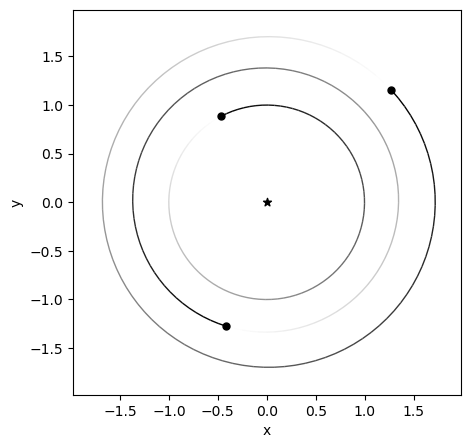

In [160]:
# read the CSV file into a pandas dataframe
# THIS IS THE WORK VERSION
df = pd.read_csv('/home/yba/spock/training_data/resonant/runstrings.csv', header=None, index_col=0, squeeze=True)

# convert the dataframe into a dictionary
my_dict = df.to_dict()

# the binary file name you want to search for
binary_file_name = "7622393.bin"

# search for the binary file name in the dictionary
for key, value in my_dict.items():
    if value == binary_file_name:
        i = int(key)
        
print(i)

all_data = np.loadtxt('updated_data_resonant.csv', delimiter=',',dtype=np.float64)
# get corresponding row
data = all_data[i]

# create a new simulation
sim = rebound.Simulation()
sim.G=4*np.pi**2
sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
sim.add(m=data[14], x=data[15], y=data[16], z=data[17], vx=data[18], vy=data[19], vz=data[20])
sim.add(m=data[21], x=data[22], y=data[23], z=data[24], vx=data[25], vy=data[26], vz=data[27])
fig1 = rebound.OrbitPlot(sim)


In [ ]:
def training_data(row, safolder, runfunc, args):
    try:
        df = pd.read_csv('/home/yba/spock/training_data/resonant/runstrings.csv', header=None, index_col=0, squeeze=True)
        # convert the dataframe into a dictionary
        my_dict = df.to_dict()
        # the binary file name you want to search for
        binary_file_name = row['runstring']

        # search for the binary file name in the dictionary
        for key, value in my_dict.items():
            if value == binary_file_name:
                i = int(key)


        all_data = np.loadtxt('updated_data_resonant.csv', delimiter=',',dtype=np.float64)
        # get corresponding row
        data = all_data[i]
        # create a new simulation
        sim = rebound.Simulation()
        sim.G=4*np.pi**2
        sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
        sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
        sim.add(m=data[14], x=data[15], y=data[16], z=data[17], vx=data[18], vy=data[19], vz=data[20])
        sim.add(m=data[21], x=data[22], y=data[23], z=data[24], vx=data[25], vy=data[26], vz=data[27])
        
#         string = row['runstring'] # should get something like: xxxxxxx.bin, eg 0000001.bin
#         intRow = int(string[:-4])  # remove the last four characters '.bin' and convert to integer
#         # intRow get the binary file number of the binary file
#         intRow = int(string[:-4])  # remove the last four characters '.bin' and convert to integer
#         all_data = np.loadtxt('data.csv', delimiter=',',dtype=np.float64)
#         data = all_data[intRow]
#         # create a new simulation
#         sim = rebound.Simulation()
#         sim.G=4*np.pi**2
#         sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
#         sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
#         sim.add(m=data[14], x=data[15], y=data[16], z=data[17], vx=data[18], vy=data[19], vz=data[20])
#         sim.add(m=data[21], x=data[22], y=data[23], z=data[24], vx=data[25], vy=data[26], vz=data[27])

    except:
        print("training_data_functions.py Error reading " + safolder+'sa'+row['runstring'])
        return None

In [111]:
# figure out which row going wrong

# read the CSV file into a pandas dataframe
df = pd.read_csv('/home/yba/spock/training_data/resonant/runstrings.csv', header=None, index_col=0, squeeze=True)

# convert the dataframe into a dictionary
my_dict = df.to_dict()


# search for the binary file name in the dictionary
all_data = np.loadtxt('data_resonant.csv', delimiter=',',dtype=np.float64)

for key, value in my_dict.items():
    try:
        # get corresponding row
        index = int(key)
        binary_file_name = value
        data = all_data[index]
        sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa'+ binary_file_name) # read the file
        sim = sa[0]   # read the initial condition
        m0 = sim.particles[0].m
        if m0 != data[0]:
            print(key,value)
            break
    except:
        pass

    


/tmp/ipykernel_141347/2749443022.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv('/home/yba/spock/training_data/resonant/runstrings.csv', header=None, index_col=0, squeeze=True)


3000.0 0003001.bin


/tmp/ipykernel_141347/4166026181.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv('/home/yba/spock/training_data/resonant/runstrings.csv', header=None, index_col=0, squeeze=True)


3000


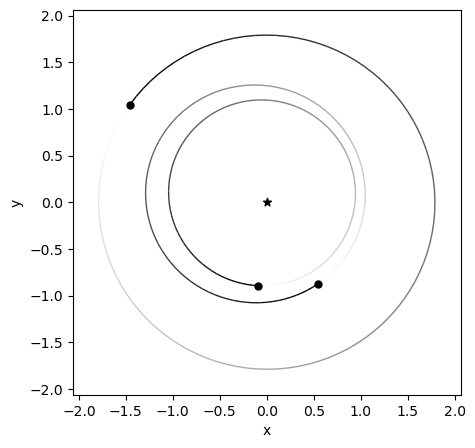

In [140]:
# test 

# read the CSV file into a pandas dataframe
df = pd.read_csv('/home/yba/spock/training_data/resonant/runstrings.csv', header=None, index_col=0, squeeze=True)

# convert the dataframe into a dictionary
my_dict = df.to_dict()

# the binary file name you want to search for
binary_file_name = "00003002.bin"

# search for the binary file name in the dictionary
for key, value in my_dict.items():
    if value == binary_file_name:
        index = int(key)
print(index)


all_data = np.loadtxt('data_resonant.csv', delimiter=',',dtype=np.float64)
# get corresponding row
data = all_data[index]

# create a new simulation
sim = rebound.Simulation()
sim.G=4*np.pi**2
sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
sim.add(m=data[14], x=data[15], y=data[16], z=data[17], vx=data[18], vy=data[19], vz=data[20])
sim.add(m=data[21], x=data[22], y=data[23], z=data[24], vx=data[25], vy=data[26], vz=data[27])
fig1 = rebound.OrbitPlot(sim)


In [6]:
all_data = np.loadtxt('data_resonant.csv', delimiter=',',dtype=np.float64)
print(len(all_data))

In [11]:
# Read the CSV file, contain all data
all_data = np.loadtxt('data.csv', delimiter=',',dtype=np.float64)
#choose a specific row
data = all_data[23605]

[ 1.00000000e+00  2.14627157e-06  2.06510593e-06 -4.21982081e-08
 -1.19883754e-05  1.17710358e-05  1.51190489e-08  2.33158459e-07
  6.17311757e-01 -7.85454751e-01 -4.10883918e-04  4.95084648e+00
  3.87885597e+00  2.29475329e-02  3.65517814e-06 -6.60049326e-01
 -8.68019240e-01  9.22459660e-03  4.78937823e+00 -3.63220870e+00
 -8.67113019e-03  1.13745163e-06  1.07604434e-01  1.13481260e+00
  7.54007032e-03 -5.86573245e+00  5.28326623e-01  9.86860883e-03]


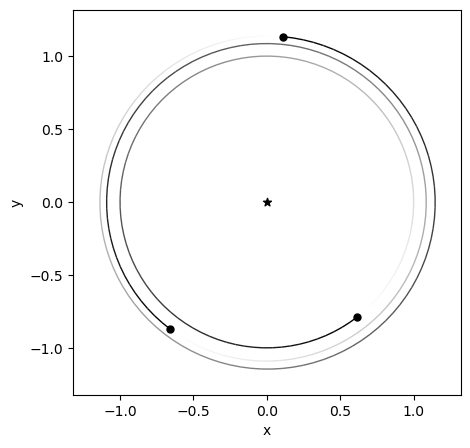

In [12]:
#import numpy as np
#import rebound

# Read the CSV file, contain all data
all_data = np.loadtxt('data.csv', delimiter=',',dtype=np.float64)
#choose a specific row
data = all_data[23605]


print(data)
#plot
sim = rebound.Simulation()
sim.G=4*np.pi**2
sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
sim.add(m=data[14], x=data[15], y=data[16], z=data[17], vx=data[18], vy=data[19], vz=data[20])
sim.add(m=data[21], x=data[22], y=data[23], z=data[24], vx=data[25], vy=data[26], vz=data[27])
fig1 = rebound.OrbitPlot(sim)


In [15]:
def training_data_new(row, safolder, runfunc, args):
    try:
        #old code:
        #sa = rebound.SimulationArchive(safolder+'sa'+row['runstring'])
        #sim = sa[0]
        string = row['runstring'] # should get something like: xxxxxxx.bin, eg 0000001.bin
        # intRow get the binary file number of the binary file
        intRow = int(string[:-4])  # remove the last four characters '.bin' and convert to integer

        # read our csv
        all_data = np.loadtxt('data.csv', delimiter=',',dtype=np.float64)
        # get corresponding row
        data = all_data[intRow]
        # create a new simulation
        sim = rebound.Simulation()
        sim.G=4*np.pi**2
        sim.add(m=data[0], x=data[1], y=data[2], z=data[3], vx=data[4], vy=data[5], vz=data[6])
        sim.add(m=data[7], x=data[8], y=data[9], z=data[10], vx=data[11], vy=data[12], vz=data[13])
        sim.add(m=data[14], x=data[15], y=data[16], z=data[17], vx=data[18], vy=data[19], vz=data[20])
        sim.add(m=data[21], x=data[22], y=data[23], z=data[24], vx=data[25], vy=data[26], vz=data[27])
        #fig1 = rebound.OrbitPlot(sim)
        
    except:
        print("training_data_functions.py Error reading " + safolder+'sa'+row['>
        return None

    init_sim_parameters(sim)

    try:
        ret, stable = runfunc(sim, args)
    except:
        print('{0} failed'.format(row['runstring']))
        return None

    r = ret[0] # all runfuncs return list of features for all adjacent trios (t>
    return pd.Series(r, index=list(r.keys())) # conert OrderedDict to pandas Se>



SyntaxError: EOL while scanning string literal (239008452.py, line 16)

In [14]:
runstring = "0001358.bin"
intRow = int(runstring[:-4])
print(intRow)

1358


In [19]:
sim.status()

---------------------------------
REBOUND version:     	3.6.1
REBOUND built on:    	Apr 22 2023 16:40:11
Number of particles: 	4
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.Particle object, m=0.9999909535058207 x=-7.7923843895e-06 y=2.47492960537e-05 z=1.4730816762e-06 vx=-8.69515023557e-05 vy=-4.42512042873e-05 vz=-7.731798446e-07>
<rebound.Particle object, m=9.0464941793e-06 x=0.4893481138428634 y=0.9127183584491096 z=-0.0171435739709339 vx=-5.1609613203938185 vy=3.180845018481656 vz=0.0254224033165896>
<rebound.Particle object, m=1.62646271485e-05 x=-0.3390330161654474 y=-1.0758160969177066 z=0.0024234267819713 vx=5.858070498586392 vy=-1.514460031414457 vz=-0.0196118609022865>
<rebound.Particle object, m=1.10375718009e-05 x=0.8044952994521216 y=-1.4050396282278632 z=-0.1229795162709402 vx=3.4754011585714637 vy=3.633719126814286 vz=0.0781121832968897>
-------------------------------

In [20]:
sim2.status()

---------------------------------
REBOUND version:     	3.6.1
REBOUND built on:    	Apr 22 2023 16:40:11
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999909535058207 x=-7.792384389495917e-06 y=2.4749296053744294e-05 z=1.4730816762143302e-06 vx=-8.695150235573335e-05 vy=-4.425120428732506e-05 vz=-7.731798445936597e-07>
<rebound.Particle object, m=9.046494179256723e-06 x=0.48934811384286336 y=0.9127183584491096 z=-0.017143573970933922 vx=-5.1609613203938185 vy=3.180845018481656 vz=0.025422403316589588>
<rebound.Particle object, m=1.6264627148498612e-05 x=-0.3390330161654474 y=-1.0758160969177066 z=0.002423426781971316 vx=5.858070498586392 vy=-1.514460031414457 vz=-0.01961186090228651>
<rebound.Particle object, m=1.1037571800898434e-05 x=0.8044952994521216 y=-1.4050396282278632 z=-0.12297951627094018 vx=3.4754011585714637 vy=3.633719126814286

In [66]:
import sys
# sys.path.append('../spock/')
# from additional_feature_functions import additional_features
# sa = rebound.SimulationArchive(datafolder+'random/simulation_archives/runs/sa0003131.bin')
# sim = sa[0]

ModuleNotFoundError: No module named 'spock'

In [67]:
features = additional_features(sim, (10000, 80, [[1,2,3]]))

NameError: name 'additional_features' is not defined

In [39]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0

def testsim(sim, times):
    sim.collision_resolve = collision
    sim.ri_whfast.keep_unsynchronized = 1
    sim.init_megno()
    val = np.zeros((Nout, 19))
    for i, time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        orbits = sim.calculate_orbits()
        for j, o in enumerate(orbits):
            val[i,0] = sim.t
            val[i,6*j+1] = o.a
            val[i,6*j+2] = o.e
            val[i,6*j+3] = o.inc
            val[i,6*j+4] = o.Omega
            val[i,6*j+5] = o.pomega
            val[i,6*j+6] = o.M
    return sim, val

# Random

In [72]:
%%time
sa = rebound.SimulationArchive(datafolder+'random/simulation_archives/runs/sa0000000.bin')
tmax = sa[1].t
sim = sa[0]

times = np.linspace(0, tmax, Nout)
sim, val = testsim(sim, times) # one of the data generation functions we run over short period
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Feb 13 2023 16:41:40
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	1.0000000277011167e+06
Current timestep:    	0.034640
---------------------------------
<rebound.Particle object, m=1.0 x=-9.00869716811629e-06 y=-4.0957168394135314e-05 z=2.771654256752689e-07 vx=0.00023981147897707796 vy=-2.6983802537851203e-05 vz=3.565360353775143e-07>
<rebound.Particle object, m=3.4140160192072926e-05 x=-0.2812557303539579 y=0.9783219977167086 z=0.0019541396683530475 vx=-5.8973301355293035 vy=-1.825510037607189 vz=0.022097193462274393>
<rebound.Particle object, m=1.8787249753397036e-05 x=1.149691589067434 y=0.45210087389972753 z=-0.019073186568699985 vx=-2.1653672964524864 vy=5.182472977207462 vz=-0.023773699580198402>
<rebound.Particle object, m=1.8268998599127623e-06 x=-1.6359572992202371 y=-0.512690036377667 z=0.007911026206695546 vx=1.2072981174939548 vy=-4.410425927458735 vz=-0.36361

In [73]:
sim = sa[1]
sim.integrator_synchronize()
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Feb 13 2023 16:41:40
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000277011167e+06
Current timestep:    	0.034640
---------------------------------
<rebound.Particle object, m=1.0 x=-3.629182535523935e-05 y=1.1843522755585879e-05 z=9.692032962716543e-08 vx=-2.753997584918462e-05 vy=-0.0002174400836347144 vz=-8.431557497955291e-07>
<rebound.Particle object, m=3.4140160192072926e-05 x=0.9225193262954728 y=0.4107034942938748 z=-0.007950327673330494 vx=-2.4266312875245175 vy=5.726893721352419 vz=0.04678499897728613>
<rebound.Particle object, m=1.8787249753397036e-05 x=0.16981871403865156 y=-1.2279135896541034 z=0.011612920399274694 vx=5.527494030376944 vy=0.9037972044771627 vz=-0.06443832825556559>
<rebound.Particle object, m=1.8268998599127623e-06 x=0.87932635067516 y=-1.5303994574427984 z=-0.02390372135108166 vx=3.5793674392077772 vy=2.705759021771257 vz=0.2498918341235

# Naireen

In [74]:
%%time
sa = rebound.SimulationArchive(datafolder+'distributions/Sys_1_1e8/simulation_archives/sa0000000.bin')
tmax = sa[1].t
sim = sa[0]
times = np.linspace(0, tmax, Nout)
sim, val = testsim(sim, times) # one of the data generation functions we run over short period
sim.status()

RuntimeError: Cannot read binary file. Check filename and file contents.

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Feb 13 2023 16:41:40
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000277011167e+06
Current timestep:    	0.034640
---------------------------------
<rebound.Particle object, m=1.0 x=-3.629182535523935e-05 y=1.1843522755585879e-05 z=9.692032962716543e-08 vx=-2.753997584918462e-05 vy=-0.0002174400836347144 vz=-8.431557497955291e-07>
<rebound.Particle object, m=3.4140160192072926e-05 x=0.9225193262954728 y=0.4107034942938748 z=-0.007950327673330494 vx=-2.4266312875245175 vy=5.726893721352419 vz=0.04678499897728613>
<rebound.Particle object, m=1.8787249753397036e-05 x=0.16981871403865156 y=-1.2279135896541034 z=0.011612920399274694 vx=5.527494030376944 vy=0.9037972044771627 vz=-0.06443832825556559>
<rebound.Particle object, m=1.8268998599127623e-06 x=0.87932635067516 y=-1.5303994574427984 z=-0.02390372135108166 vx=3.5793674392077772 vy=2.705759021771257 vz=0.2498918341235

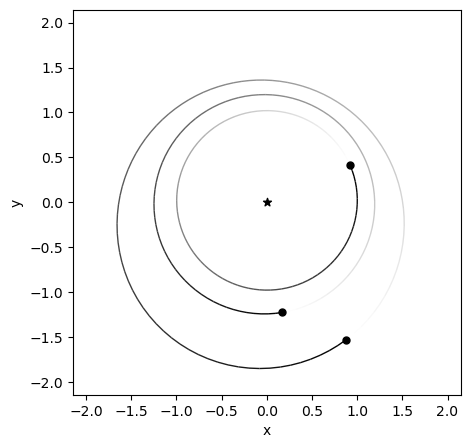

In [37]:
sim = sa[1]
sim.integrator_synchronize() # need this step with new sim archive because we used safe_mode = 0
sim.status()
fig = rebound.OrbitPlot(sim)

# Resonant

In [56]:
7*3600/0.5

50400.0

In [68]:
%%time
import time
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa0000000.bin')
#tmax = sa[1].t
sim = sa[0]
#sim.dt*=2

CPU times: user 4.26 ms, sys: 0 ns, total: 4.26 ms
Wall time: 2.43 ms


In [69]:
a = np.array([1,2,3])
np.save("/home/yba/test/test.npy", a)
b = np.load("/home/yba/test/test.npy")
a == b

array([ True,  True,  True])

In [71]:
from spock import FeatureClassifier

ModuleNotFoundError: No module named 'spock'

In [70]:
model = FeatureClassifier()
model.predict(sim)

NameError: name 'FeatureClassifier' is not defined

In [75]:
from spock.simsetup import set_sim_parameters, set_timestep
sim.init_megno(seed=0)
sim.integrator_synchronize()
#sim.ri_whfast.keep_unsynchronized = 0
#sim.ri_whfast.safe_mode = 1
#set_sim_parameters(sim)
set_timestep(sim, 0.05)
model.predict(sim, manual=True)

ModuleNotFoundError: No module named 'spock'

In [ ]:
fig = rebound.OrbitPlot(sim)

In [19]:
sim = sa[-1]
sim.t

22660.663202314823

In [16]:
sa[-1].t

10000.000000000007

In [17]:
len(sa)

2

In [4]:
from spock import FeatureClassifier

model = FeatureClassifier()

In [8]:
%%time
model.predict(sim, copy=False)

CPU times: user 1.09 s, sys: 18.1 ms, total: 1.11 s
Wall time: 944 ms


0.9789295792579651

In [9]:
1500/60

25.0

In [28]:
sim2 = sa[1]
sim2.t

206440676.91538927

In [15]:
sim.integrate(1e6)

In [16]:
sim.integrator

'whfast'

In [27]:
sim.G

39.47841760435743

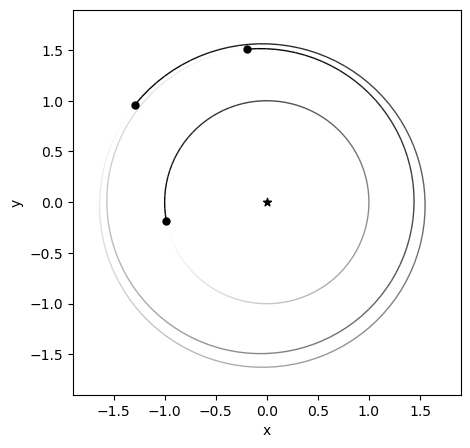

In [23]:
%matplotlib inline
fig = rebound.OrbitPlot(sim)

In [ ]:
# rebound binaries


# Ari

In [5]:
sa = rebound.SimulationArchive(datafolder+'nonressystems/Kepler-431/simulation_archives/runs/sa0000000.bin')

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


# The innermost planet now has a different orbital period, but the timestep is still the same fraction to close to machine precision:

In [6]:
sim = sa[0]
sim.dt/sim.particles[1].P

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


0.03464101615137755

In [9]:
%%time
tmax = sa[1].t
sim = sa[0]
times = np.linspace(0, tmax, Nout)
sim, val = testsim(sim, times) # one of the data generation functions we run over short period
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	May 30 2019 11:47:14
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	5.2867929037495232e+04
Current timestep:    	0.001831
---------------------------------
<rebound.Particle object, m=0.51 x=-9.243438619388608e-06 y=-5.843309887933348e-06 z=-5.364867056784226e-09 vx=0.00025812578933250956 vy=-0.0004070578950174552 vz=3.717095432586538e-07>
<rebound.Particle object, m=6.606794029325489e-06 x=0.029415138260382036 y=-0.011719099624968315 z=-2.0293887473444915e-05 vx=1.555005645878225 vy=3.789031687122423 vz=-0.000406892740939987>
<rebound.Particle object, m=2.110761752620521e-05 x=0.018112352912284243 y=0.04141347641253959 z=2.7088584243370827e-05 vx=-3.0000505678412064 vy=1.485960978933363 vz=-0.004054656657424565>
<rebound.Particle object, m=6.33670720508826e-05 x=0.0652942480233223 y=0.034455969465934946 z=3.627095560720546e-05 vx=-1.2402945581572582 vy=2.3861143277678045 vz=

In [8]:
sim = sa[1]
sim.integrator_synchronize() # need this step with new sim archive because we used safe_mode = 0
sim.status()

---------------------------------
REBOUND version:     	3.8.2
REBOUND built on:    	May  7 2019 13:37:40
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	5.2867929037495232e+04
Current timestep:    	0.001831
---------------------------------
<rebound.Particle object, m=0.51 x=-9.243438619388608e-06 y=-5.843309887933348e-06 z=-5.364867056784226e-09 vx=0.00025812578933250956 vy=-0.0004070578950174552 vz=3.717095432586538e-07>
<rebound.Particle object, m=6.606794029325489e-06 x=0.029415138260382036 y=-0.011719099624968315 z=-2.0293887473444915e-05 vx=1.555005645878225 vy=3.789031687122423 vz=-0.000406892740939987>
<rebound.Particle object, m=2.110761752620521e-05 x=0.018112352912284243 y=0.04141347641253959 z=2.7088584243370827e-05 vx=-3.0000505678412064 vy=1.485960978933363 vz=-0.004054656657424565>
<rebound.Particle object, m=6.33670720508826e-05 x=0.0652942480233223 y=0.034455969465934946 z=3.627095560720546e-05 vx=-1.2402945581572582 vy=2.3861143277678045 vz=

# Test to show that even though I'm not reproducible when using newest REBOUND on old (random) integrations, I can still load the binary and get the latest time and masses, so I can always use same commit for generate_data/generate_metadata.py


In [10]:
sim = rebound.Simulation(datafolder+'random/final_conditions/runs/fc0000000.bin')
sim.t

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:352: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:352: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:352: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


12356442.121674882

In [12]:
sa = rebound.SimulationArchive(datafolder+'random/simulation_archives/runs/sa0000000.bin')
sim = sa[0]

In [13]:
sim.particles[1].m

3.4140160192072926e-05

# To get same outputs when stopping at different points with MEGNO, need to pass seed to init_megno, and need to use exact_finish_time=0

In [27]:
%%time
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa0000000.bin')
sim = sa[0]
sim.ri_whfast.keep_unsynchronized = 1
sim.init_megno(seed=0)
    
times = np.linspace(0, 1e4, 1000)
for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    
#sim.integrate(1e4, exact_finish_time=0)
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Jul 26 2019 10:18:51
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	1.0000029978431428e+04
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=1.5754637080804735e-05 y=5.552715431442515e-06 z=-1.1669878145708697e-08 vx=-7.301349514488498e-06 vy=4.705456663283622e-05 vz=-1.0008721700251636e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=0.18820747244699707 y=0.9983892059722129 z=-0.006260219550608885 vx=-6.069045419128382 vy=1.1841416303639263 vz=-0.03798729681251473>
<rebound.Particle object, m=1.2444171101394952e-05 x=-1.3363731009885487 y=-0.7954836546826433 z=0.0021957760487688422 vx=2.628852215552226 vy=-4.19628486689365 vz=0.023007745192562795>
<rebound.Particle object, m=2.531702420746453e-07 x=0.4956723760588331 y=1.4533313436553013 z=0.036701363708389 vx=-4.850118344763209 vy=1.7624426656878491 vz=